### TF예제 : https://www.tensorflow.org/tutorials/generative/dcgan 

In [711]:
# Import Modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
import cv2
import random
import math
import glob
from tqdm import tqdm
import re

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Flatten, Conv2D, MaxPool2D, LSTM, Activation, AveragePooling2D
from keras.optimizers import Adam, RMSprop
from keras.losses import categorical_crossentropy
from keras import layers, regularizers,activations
from keras.utils import to_categorical,Sequence
from keras import optimizers, initializers, regularizers, metrics
from keras.preprocessing import image

# sklearn
import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings(action='ignore') 

In [712]:
# train data into list
all_input_list = sorted(glob.glob('./data/train_input/*.csv'))
all_target_list = sorted(glob.glob('./data/train_target/*.csv'))
len(all_input_list), len(all_target_list)

(28, 28)

In [754]:
# split data - training(25) : validation(3)
train_input_list = all_input_list[:28]
train_target_list = all_target_list[:28]

val_input_list = all_input_list[28:]
val_target_list = all_target_list[28:]

print(f'training: {len(train_input_list)}, validation: {len(val_input_list)}')

training: 28, validation: 0


In [755]:
# make custom dataset using Sequence
class Dataloader(tf.keras.utils.Sequence):
    def __init__(self, input_paths, target_paths, batch_size, infer_mode, shuffle=False):
        self.input_paths = input_paths
        self.target_paths = target_paths
        self.batch_size = batch_size
        self.infer_mode = infer_mode
        self.shuffle = shuffle

        self.data_list = []
        self.label_list = []
        print('Data Pre-processing..')

        for input_path, target_path in tqdm(zip(self.input_paths, self.target_paths)):
            input_df = pd.read_csv(input_path)
            target_df = pd.read_csv(target_path)

            input_df = input_df.drop(columns=['obs_time'])
            input_df = input_df.fillna(0)


            target_length = int(len(target_df))

            for idx in range(target_length):
                time_series = input_df[24*idx:24*(idx+1)].values
                self.data_list.append(time_series)

            for label in target_df['predicted_weight_g']:
                self.label_list.append(label)
        print('Done. \n')
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.data_list)/self.batch_size)

    def __getitem__(self, idx):
        global data_GAN
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        data = [self.data_list[i] for i in indices]
        label = [self.label_list[i] for i in indices]
        data_GAN = data
        if self.infer_mode == False:
            return tf.convert_to_tensor(data), tf.convert_to_tensor(label)
        else:
            return tf.convert_to_tensor(data)
        
    def on_epoch_end(self):
        self.indices = np.arange(len(self.data_list))

        if self.shuffle == True:
            np.random.shuffle(self.indices)

In [756]:
CFG = {
    'EPOCHS':20,
    'LEARNING_RATE':1e-3,   
    'BATCH_SIZE':32,        
    'SEED':2023}

In [757]:
# train data preprocessing 
train_loader = Dataloader(train_input_list, train_target_list, CFG['BATCH_SIZE'], False, shuffle=False)
# val_loader = Dataloader(val_input_list, val_target_list, CFG['BATCH_SIZE'], False, shuffle=False)

Data Pre-processing..


28it [00:00, 165.03it/s]

Done. 



In [758]:
np.array(data_GAN).shape

(16, 24, 15)

In [759]:
# train data shape
# (batch, sequence, feature)
t = []
p = []
for i, (data, labels) in enumerate(train_loader):
    t.append(data)
    p.append(labels)

# for i, (data, labels) in enumerate(val_loader):
#     print(data.shape)
#     break

In [760]:
len(t)

25

### Vanila GAN

In [719]:
# Generator 모델 작성
# G 모델은 Noise로 부터 원래의 데이터를 생성해내는 모델입니다.
# Input : (24*15,)
# Output : Mnist 이미지 크기인 1일치인 (24,15)
inputs = keras.Input(shape=(360,))
x = inputs
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(24*15, activation = 'linear')(x)
outputs = layers.Reshape((24, 15))(x)

In [720]:
G = keras.Model(inputs, outputs)
G.summary()

Model: "model_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_70 (InputLayer)       [(None, 360)]             0         
                                                                 
 dense_291 (Dense)           (None, 512)               184832    
                                                                 
 dense_292 (Dense)           (None, 512)               262656    
                                                                 
 dense_293 (Dense)           (None, 512)               262656    
                                                                 
 dense_294 (Dense)           (None, 1024)              525312    
                                                                 
 dense_295 (Dense)           (None, 1024)              1049600   
                                                                 
 dense_296 (Dense)           (None, 1024)              104

In [721]:
# Discriminaotr 모델 작성
# D모델은 28*28 이미지가 실제 데이터인지 만들어진 데이터인지 판별합니다.
# Input : Mnist 이미지 (28*28)
# Output : 실제 데이터 일 확률 (0~1 사이의 값)
inputs = keras.Input(shape=(24, 15))
x = layers.Flatten()(inputs)
x = layers.Dense(512, activation='leaky_relu')(x)
x = layers.Dense(512, activation='leaky_relu')(x)
x = layers.Dense(512, activation='leaky_relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(1024, activation='leaky_relu')(x)
x = layers.Dense(1024, activation='leaky_relu')(x)
x = layers.Dense(1024, activation='leaky_relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

In [722]:
D = keras.Model(inputs, outputs)
D.summary()

Model: "model_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_71 (InputLayer)       [(None, 24, 15)]          0         
                                                                 
 flatten_33 (Flatten)        (None, 360)               0         
                                                                 
 dense_298 (Dense)           (None, 512)               184832    
                                                                 
 dense_299 (Dense)           (None, 512)               262656    
                                                                 
 dense_300 (Dense)           (None, 512)               262656    
                                                                 
 dropout_71 (Dropout)        (None, 512)               0         
                                                                 
 dense_301 (Dense)           (None, 1024)              525

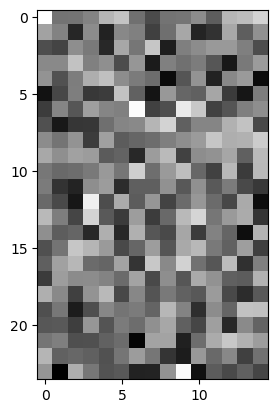

In [723]:
# 임의의 Noise를 G모델에 통과시키면 28*28 사이즈의 랜덤 이미지가 만들어집니다.
test_noise = tf.random.normal([1, 360])
fake_image_test = G(test_noise, training=False)

plt.imshow(fake_image_test[0], cmap='gray')

In [724]:
# 그리고 G모델에서 만들어진 이미지를 D모델에 통과시키면 확률이 나오게 됩니다.
decision = D(fake_image_test, training=False)
print(decision)

tf.Tensor([[0.50131893]], shape=(1, 1), dtype=float32)


# GAN 훈련 구현
 - G모델, D모델을 훈련시킬 Loss를 생성해줍니다.
 - G모델과 D모델을 순서대로 훈련시키는 과정을 반복합니다.

In [725]:
noise_dim = 360

seed = tf.random.normal([CFG['BATCH_SIZE'], noise_dim])

G_optimizer = tf.keras.optimizers.Adam(1e-4)
D_optimizer = tf.keras.optimizers.Adam(1e-4)

In [726]:
cross_entropy = tf.keras.losses.BinaryFocalCrossentropy(from_logits=True)

def D_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def G_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [727]:
# 아래의 train_step 함수에는 @tf.function이라는 데코레이터가 사용됩니다.
# 특정한 상황일때 함수를 'compile' 하여 속도가 빨라진다고 대략적으로 이해하시면 됩니다!
@tf.function
def train_step(real_datas):  
  
  noises = tf.random.normal([CFG['BATCH_SIZE'], noise_dim])
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as dsc_tape:
    fake_datas = G(noises, training=True)
    
    real_output = D(real_datas, training=True)
    fake_output = D(fake_datas, training=True)
    
    gen_loss = G_loss(fake_output)
    dsc_loss = D_loss(real_output, fake_output)
    
  gen_gradients = gen_tape.gradient(gen_loss, G.trainable_variables)
  dsc_gradients = dsc_tape.gradient(dsc_loss, D.trainable_variables)
  
  G_optimizer.apply_gradients(zip(gen_gradients, G.trainable_variables))
  D_optimizer.apply_gradients(zip(dsc_gradients, D.trainable_variables))
  

In [728]:
def test_step(real_datas):  
  noises = tf.random.normal([CFG['BATCH_SIZE'], noise_dim])
  
  fake_datas = G(noises, training=False)
  
  real_output = D(real_datas, training=False)
  fake_output = D(fake_datas, training=False)    
  
  gen_loss = G_loss(fake_output)
  dsc_loss = D_loss(real_output, fake_output)
  
  print("Generator loss:", gen_loss.numpy(), "Discriminator loss:", dsc_loss.numpy())

In [729]:
# 학습 함수

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for i, image_batch in enumerate(dataset):
      img = np.expand_dims(image_batch,axis=0)
      train_step(img)
      if i == 0:
        test_step(img)
      
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))    

In [730]:
%%time
train(data_GAN, CFG['EPOCHS'])

Generator loss: 0.1022716 Discriminator loss: 3098.682
Time for epoch 1 is 1.9583971500396729 sec
Generator loss: 0.00079552096 Discriminator loss: 2.4406068
Time for epoch 2 is 1.268395185470581 sec
Generator loss: 6.308653e-05 Discriminator loss: 3.8661222
Time for epoch 3 is 1.0845251083374023 sec
Generator loss: 0.00014284375 Discriminator loss: 3.395431
Time for epoch 4 is 1.155393123626709 sec
Generator loss: 0.00031985564 Discriminator loss: 3.0027342
Time for epoch 5 is 1.2487781047821045 sec
Generator loss: 1.6030746e-05 Discriminator loss: 4.6590166
Time for epoch 6 is 1.1533992290496826 sec
Generator loss: 2.0903783e-06 Discriminator loss: 5.731611
Time for epoch 7 is 1.1040430068969727 sec
Generator loss: 1.2087673e-05 Discriminator loss: 4.862102
Time for epoch 8 is 1.063450813293457 sec
Generator loss: 1.8881137e-13 Discriminator loss: 15.422127
Time for epoch 9 is 1.143852710723877 sec
Generator loss: 4.518965e-15 Discriminator loss: 18.30748
Time for epoch 10 is 1.18364

In [731]:
data_GAN

[array([[0.00000000e+00, 1.58130953e+01, 6.89690464e+01, 6.04000000e+01,
         1.03580049e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.68142857e+01, 6.75571418e+01, 1.26800000e+02,
         1.03702821e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.78154762e+01, 6.61452372e+01, 1.93200000e+02,
         1.03825592e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.88166667e+01, 6.47333325e+01, 2.59600000e+02,
         1.03948364e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00

In [732]:
# 임의의 Noise를 G모델에 통과시키면 28*28 사이즈의 랜덤 이미지가 만들어집니다.
test_noise = tf.random.normal([1, 360])
fake_data = G(test_noise, training=False)

fake_data

<tf.Tensor: shape=(1, 24, 15), dtype=float32, numpy=
array([[[  7.2481046 ,  11.428395  ,  13.670298  ,  -5.003024  ,
           2.1780508 ,  10.331518  ,  -4.5565934 ,  -8.308068  ,
          -2.0508642 ,   2.0808775 ,   0.67721057,  -4.03759   ,
          -5.0329866 , -12.06667   ,   2.9656708 ],
        [  3.1072152 , -15.092402  ,   4.007843  ,  18.013876  ,
           9.593215  ,   4.8987966 , -21.301186  ,  -3.5339835 ,
          -0.33645037,   1.7046982 , -21.651312  ,  12.383479  ,
           1.870252  ,   6.8697505 , -19.969809  ],
        [  2.9064207 ,  -7.2181106 ,  18.2177    , -10.680026  ,
          11.279275  , -18.412624  ,   8.822671  ,   0.39907652,
         -14.953288  , -18.982397  ,  -7.6429586 ,   1.2292056 ,
          16.532743  , -10.332148  , -14.915545  ],
        [ 10.195864  ,   2.4848704 ,  -0.43048108,   3.3112557 ,
          -6.375616  , -11.689034  ,  29.204967  ,  15.054917  ,
          -1.2589319 ,  -2.5927691 ,   6.435332  ,  -9.741452  ,
          -

In [733]:
GAN_df = pd.DataFrame(index=range(24*28),columns=range(15))
for i in range(24*28):
    num1 = i // 24
    num2 = i % 24
    GAN_df.loc[i] = np.array(data_GAN)[num1][num2]

In [734]:
GAN_df.to_csv('GAN_DF_LETTUCES.csv')